# Density Functional Theory calculation using a plane-wave basis set

001 | Etot =  25.72188834 Ht | eps = 2.5722e+01 | dt = 10.6246 s
002 | Etot =  -3.73540209 Ht | eps = 2.9457e+01 | dt = 9.6763 s
003 | Etot = -21.73526468 Ht | eps = 1.8000e+01 | dt = 4.0519 s
004 | Etot = -29.42671410 Ht | eps = 7.6914e+00 | dt = 3.5601 s
005 | Etot = -32.91894878 Ht | eps = 3.4922e+00 | dt = 17.6476 s
006 | Etot = -34.79324805 Ht | eps = 1.8743e+00 | dt = 17.7541 s
007 | Etot = -35.89028707 Ht | eps = 1.0970e+00 | dt = 23.9920 s
008 | Etot = -36.56316890 Ht | eps = 6.7288e-01 | dt = 15.1915 s
009 | Etot = -36.98653043 Ht | eps = 4.2336e-01 | dt = 16.9240 s
010 | Etot = -37.25642182 Ht | eps = 2.6989e-01 | dt = 12.6625 s
011 | Etot = -37.42963747 Ht | eps = 1.7322e-01 | dt = 19.0693 s
012 | Etot = -37.54120394 Ht | eps = 1.1157e-01 | dt = 23.2448 s
013 | Etot = -37.61320317 Ht | eps = 7.1999e-02 | dt = 9.9006 s


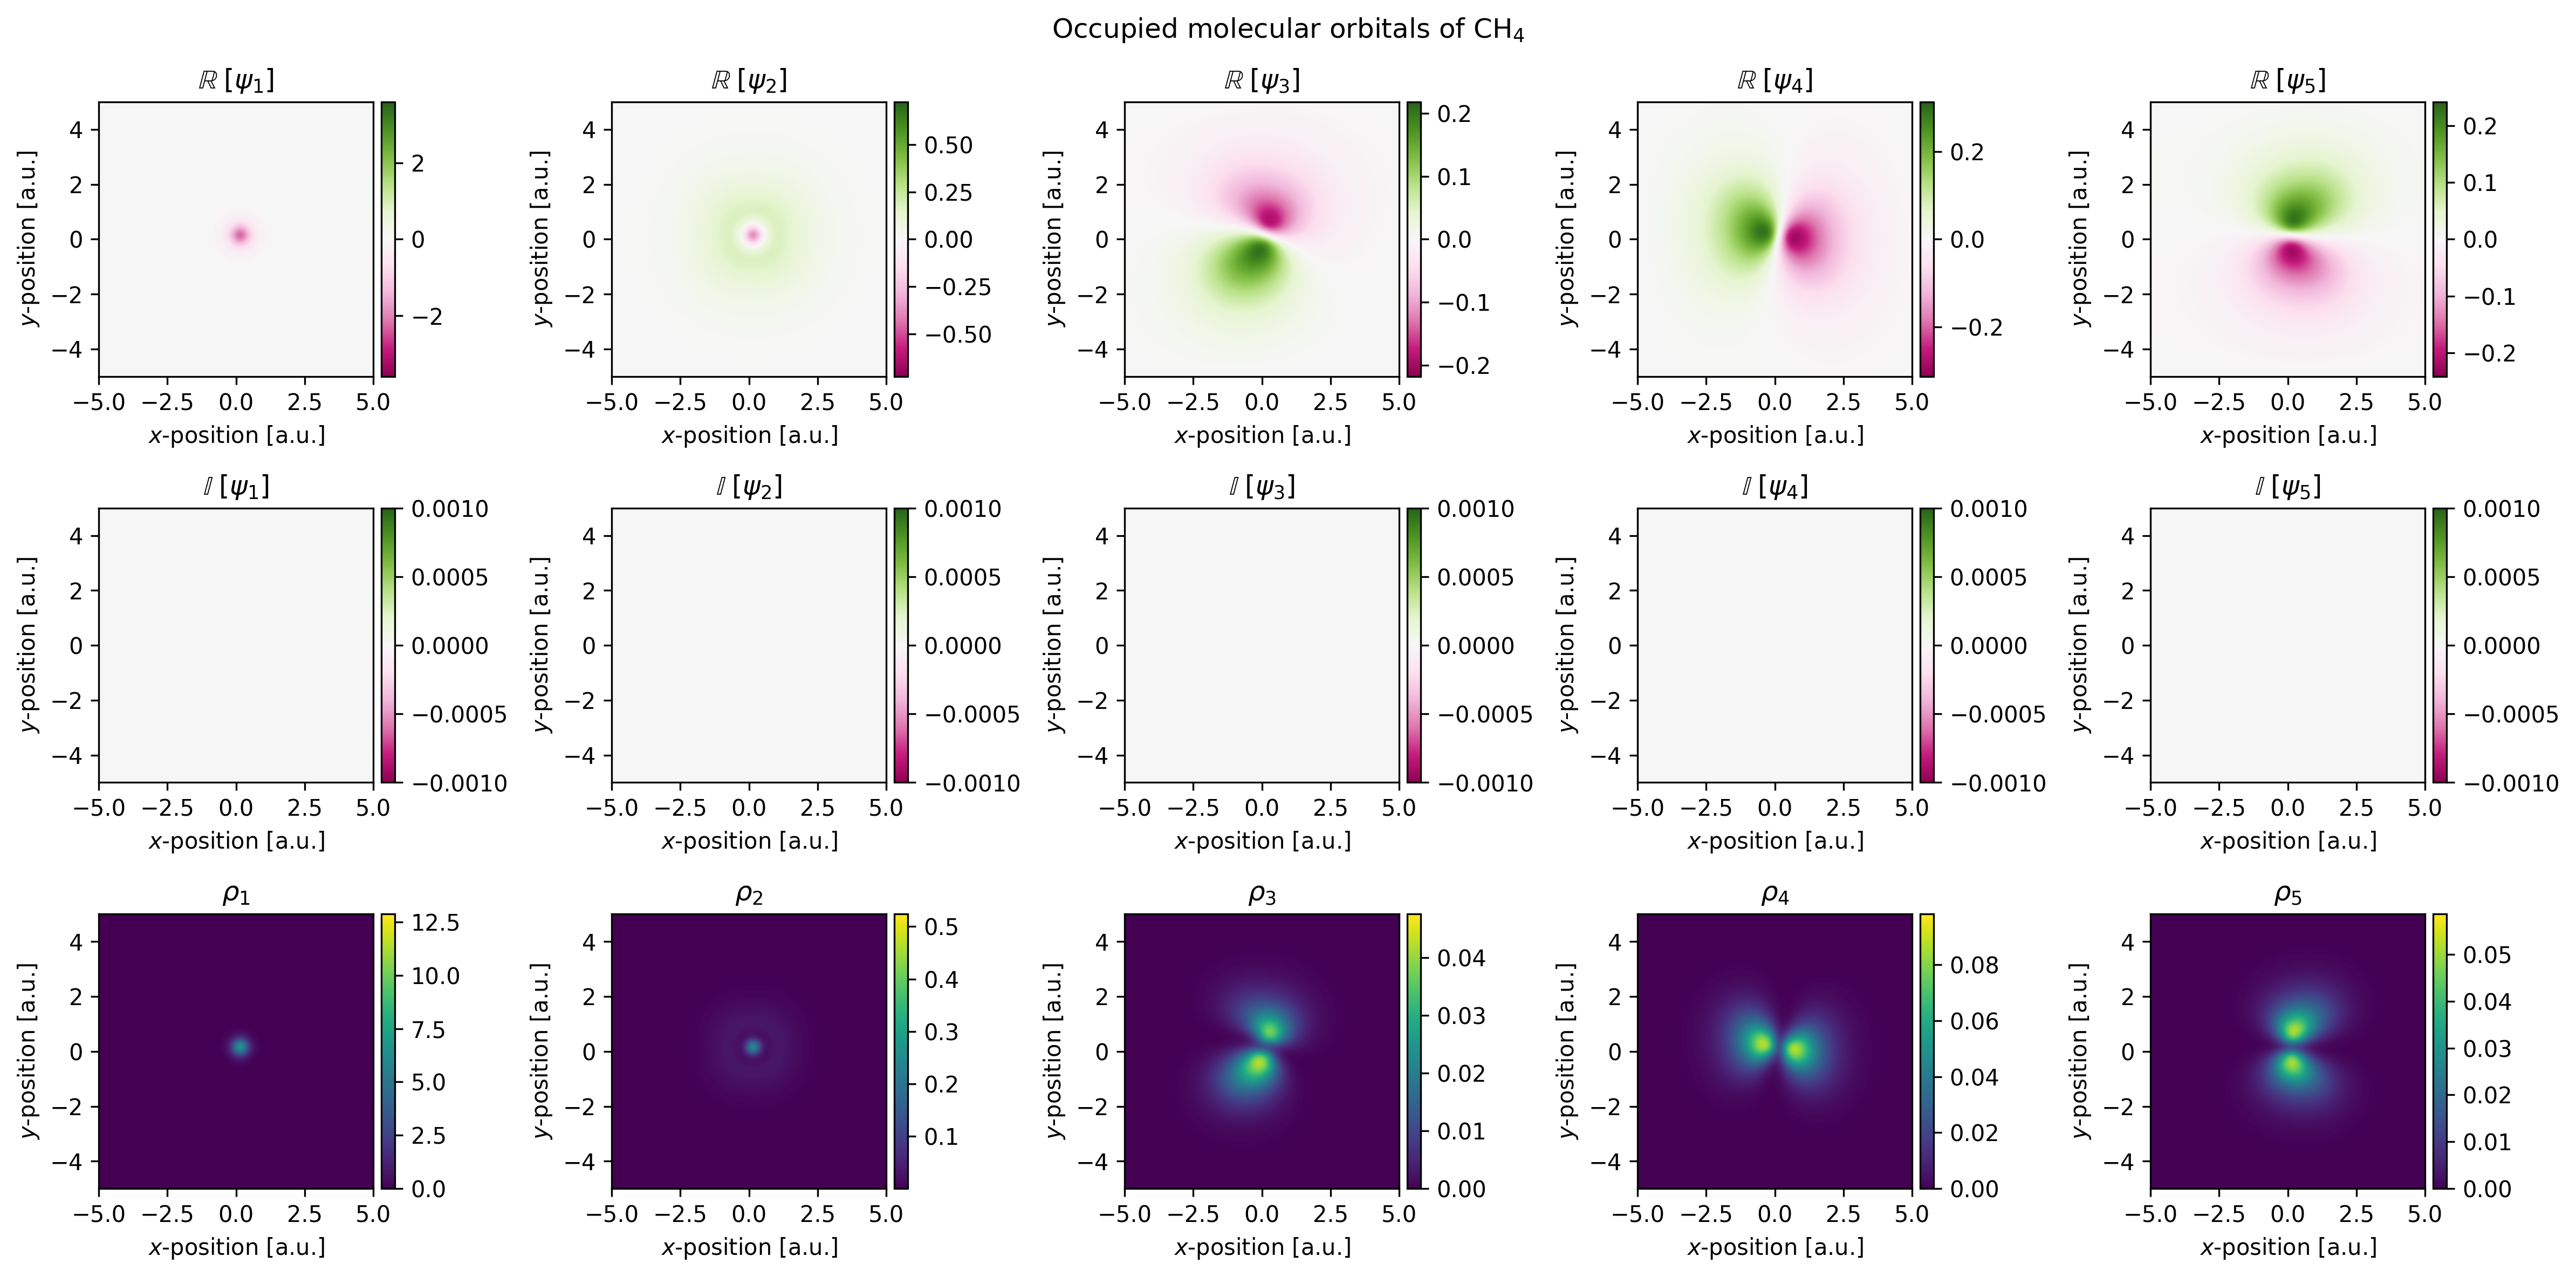

In [33]:
# import the required libraries for the test
from pypwdft import PyPWDFT, PeriodicSystem, SystemBuilder
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# create cubic periodic system with lattice size of 10 Bohr units
npts = 32   # number of grid points
sz = 10

# construct CH4 molecule system via SystemBuilder
s = SystemBuilder().from_name('CH4', sz=sz, npts=npts)

# construct calculator object
calculator = PyPWDFT(s)

# perform self-consistent field procedure and store results in res object
res = calculator.scf(tol=1e-1, verbose=True, nsol=10)

# visualize the occupied molecular orbitals
fig, im = plt.subplots(3,5, dpi=300, figsize=(16,8))
extent=[-sz/2,sz/2,-sz/2,sz/2]
orbe = res['orbe']
fig.suptitle('Occupied molecular orbitals of CH$_{4}$')
m = np.empty((3,5), dtype=object) # create placeholder for maps

for i in range(0,5):
    # visualize the real part of the wave function
    field = np.real(res['orbc_rs'][i][npts//2, :, :])
    maxval = max(np.max(np.abs(field)), 0.1)
    m[0][i] = im[0,i].imshow(field, origin='lower',
            interpolation='bicubic', extent=extent, cmap='PiYG',
            vmin=-maxval, vmax=maxval)
    im[0,i].set_title(r'$\mathbb{R}\;[\psi_{%i}]$' % (i+1))

    # visualize the imaginary part of the wave function
    field = np.imag(res['orbc_rs'][i][npts//2, :, :])
    maxval = max(np.max(np.abs(field)), 0.001)
    m[1][i] = im[1,i].imshow(field, origin='lower',
            interpolation='bicubic', extent=extent, cmap='PiYG',
            vmin=-maxval, vmax=maxval)
    im[1,i].set_title(r'$\mathbb{I}\;[\psi_{%i}]$' % (i+1))

    # visualize the electron density
    m[2][i] = im[2,i].imshow(np.real(res['orbc_rs'][i][npts//2, :, :].conj() *
                        res['orbc_rs'][i][npts//2, :, :]),
                origin='lower', interpolation='bicubic', extent=extent)
    im[2,i].set_title(r'$\rho_{%i}$' % (i+1))

for j in range(0,3):
    for i in range(0,5):
        im[j,i].set_xlabel('$x$-position [a.u.]')
        im[j,i].set_ylabel('$y$-position [a.u.]')

        divider = make_axes_locatable(im[j,i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(m[j][i], cax=cax, orientation='vertical')

plt.tight_layout()

In [34]:
# generate PyTessel object
import scipy
import pytessel

pytessel = PyTessel()

def upsample_grid(scalarfield_fft, Omega, upsample=4):
    Nx, Ny, Nz = scalarfield_fft.shape
    Nx_up = Nx * upsample
    Ny_up = Nx * upsample
    Nz_up = Nx * upsample

    # shift the frequencies
    fft = np.fft.fftshift(scalarfield_fft)

    # perform padding
    fft_upsampled = np.pad(fft, [((Nz_up-Nz)//2,),
                                ((Ny_up-Ny)//2,),
                                ((Nx_up-Nx)//2,)], 'constant')

    # shift back
    fft_hires = np.fft.ifftshift(fft_upsampled)

    return np.fft.ifftn(fft_hires) * np.prod([Nx_up, Ny_up, Nz_up]) / np.sqrt(Omega)

def optimize_real(psi):
    """
    Perform a phase transformation such that the real part of wave function
    is maximized
    """
    res = scipy.optimize.differential_evolution(real_part_psi,
                                                [(-np.pi/2,np.pi/2)], args=(psi,),
                                                tol=1e-12)
    
    deltaV = (1000 / 32**3)
    
    phase = np.exp(1j * res.x)
    print(np.degrees(res.x), 
          np.sum((psi).real**2) * deltaV, 
          np.sum((psi*phase).real**2) * deltaV)
    
    return psi * np.exp(1j * res.x)

def real_part_psi(angle, psi):
    phase = np.exp(1j * angle)
    return -np.sum((psi * phase).real**2)

for i in range(5):
    print('Building isosurfaces: %02i' % (i+1))
    scalarfield = optimize_real(upsample_grid(res['orbc_fft'][i], sz**3, 4))
    unitcell = np.identity(3) * sz

    # build positive real isosurface
    vertices, normals, indices = pytessel.marching_cubes(scalarfield.real.flatten(), scalarfield.shape, unitcell.flatten(), 0.03)
    pytessel.write_ply('MO_PR_%02i.ply' % (i+1), vertices, normals, indices)

    # build negative real isosurface
    vertices, normals, indices = pytessel.marching_cubes(scalarfield.real.flatten(), scalarfield.shape, unitcell.flatten(), -0.03)
    pytessel.write_ply('MO_NR_%02i.ply' % (i+1), vertices, normals, indices)

Building isosurfaces: 01
[-1.06897836e-07] 63.85620576112702 63.85620576112708
Building isosurfaces: 02
[8.67351406e-07] 63.99076309201569 63.99076309201573
Building isosurfaces: 03
[4.36057842e-06] 63.999938369207214 63.99993836920755
Building isosurfaces: 04
[1.74146575e-05] 63.99993839326476 63.999938393270966
Building isosurfaces: 05
[0.00037576] 63.999938425790795 63.99993842852207


In [31]:
from pytessel import PyTessel
import numpy as np
import trimesh
import pythreejs as p3
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from math import factorial
from scipy.special import assoc_laguerre
from scipy.special import lpmv
from scipy.special import sph_harm

def visualize_mesh(name):
    mesh_pos = trimesh.load_mesh(name.replace('ORB', 'P'))
    mesh_neg = trimesh.load_mesh(name.replace('ORB', 'N'))

    geometry_pos = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_pos.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_pos.faces.astype(np.uint32).ravel(), normalized=False)
        }
    )
    
    geometry_neg = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_neg.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_neg.faces.astype(np.uint32).ravel(), normalized=False),
        }
    )

    solid_material_pos = p3.MeshStandardMaterial(
        color="#276419",
        side="DoubleSide",
        transparent=True,
        opacity=0.3
    )
    solid_material_neg = p3.MeshStandardMaterial(
        color="#8e0152",
        side="DoubleSide",
        transparent=True,
        opacity=0.3
    )

    mesh_object_pos = p3.Mesh(geometry=geometry_pos, material=solid_material_pos)
    mesh_object_neg = p3.Mesh(geometry=geometry_neg, material=solid_material_neg)

    # Wireframe Overlay
    wireframe_material = p3.LineBasicMaterial(color="black", linewidth=1.0)  # Thin black lines
    wireframe_pos = p3.LineSegments(
        p3.EdgesGeometry(geometry_pos),  # Extracts edges from geometry
        wireframe_material,
        transparent=True,
        opacity=0.3
    )
    wireframe_neg = p3.LineSegments(
        p3.EdgesGeometry(geometry_neg),  # Extracts edges from geometry
        wireframe_material,
        transparent=True,
        opacity=0.3
    )

    # Atom spheres: Carbon (black) at z = -1, Oxygen (red) at z = +1
    carbon_sphere = p3.Mesh(
        geometry=p3.SphereGeometry(radius=0.2, widthSegments=32, heightSegments=32),
        material=p3.MeshStandardMaterial(color="black")
    )
    carbon_sphere.position = [0, 0, 0]

    hydrogen_spheres = []
    for i in range(4):
        hydrogen_sphere = p3.Mesh(
            geometry=p3.SphereGeometry(radius=0.15, widthSegments=32, heightSegments=32),
            material=p3.MeshStandardMaterial(color="#999999")
        )
        hydrogen_sphere.position = tuple(s.get_atom_positions()[i+1] - np.array([5,5,5]))
        hydrogen_sphere.position = (hydrogen_sphere.position[0], hydrogen_sphere.position[1], hydrogen_sphere.position[2])
        hydrogen_spheres.append(hydrogen_sphere)
    
    # Lighting setup
    ambient_light = p3.AmbientLight(color="white", intensity=4)
    
    # Create Scene
    scene = p3.Scene(children=[mesh_object_pos, 
                               mesh_object_neg, 
                               wireframe_pos, 
                               wireframe_neg, 
                               ambient_light,
                               carbon_sphere, 
                               hydrogen_spheres[0],
                               hydrogen_spheres[1],
                               hydrogen_spheres[2],
                               hydrogen_spheres[3],
                               p3.AxesHelper(size=5)
                              ])
    #scene.rotation = [np.pi / -2, 0, 0, 'XYZ']  # rotate -90° about X
    camera = p3.PerspectiveCamera(position=[7, 7, 7], fov=50)
    camera.up = [0, 0, 1]
    controller = p3.OrbitControls(controlling=camera)

    renderer = p3.Renderer(
        scene=scene, camera=camera, controls=[controller], 
        width=512, height=512, antialias=True
    )
    
    return renderer

def parse_orbital(orb):
    match = re.findall(r"-?\d+", orb)  # Extract all numbers
    return tuple(map(int, match))  # Convert to integers and return as tuple

def update_plot(N):
    name = 'MO_ORBR_%02i.ply' % N
    renderer = visualize_mesh(name)
    display(renderer)
    
# Create an interactive slider to vary the number of basis functions
N_slider = widgets.IntSlider(
    min=1, max=5, step=1, value=0,
    description="Solution index"
)

# Link slider to update function and display interactive UI
widgets.interactive(update_plot, N=N_slider)

interactive(children=(IntSlider(value=1, description='Solution index', max=5, min=1), Output()), _dom_classes=…